# Crossvalidation experiments with KuHar as base and Charm as target

This notebook will perform crossvalidation experiments using the KuHar dataset at 20 Hz as training dataset. It will contain the following steps:

1. Quick load train, test and validation CSV subsets from the balanced KuHar dataset at 20 Hz using `PandasDatasetsIO` helper
2. Quick load train, test and validation CSV subsets from other relevant datasets using `PandasDatasetsIO` helper
3. Subclassing the `Dataset` interface using `PandasMultiModalDataset`
4. Apply the fourier transform on Charm
5. Train SVM, KNN and Random Forest classification models on the KuHar dataset in the frequency domain
6. Evaluate SVM, KNN and Random Forest classification models on Charm in the frequency domain

The experiments will evaluate the performance of SVM, KNN and RF models trained on a balanced KuHar dataset and tested on Charm in the frequency domains.

## Common imports and definitions

In [1]:
from pathlib import Path  # For defining dataset Paths
import sys                # For include librep package

# This must be done if librep is not installed via pip,
# as this directory (examples) is appart from librep package root
sys.path.append("../../../..")

In [2]:
# Third party imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from umap import UMAP
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Librep imports
from librep.utils.dataset import PandasDatasetsIO          # For quick load train, test and validation CSVs
from librep.datasets.har.loaders import CHARMUnbalancedView
from librep.datasets.multimodal import PandasMultiModalDataset, TransformMultiModalDataset, WindowedTransform
from librep.transforms.fft import FFT
from librep.utils.workflow import SimpleTrainEvalWorkflow, MultiRunWorkflow
from librep.estimators import RandomForestClassifier, SVC, KNeighborsClassifier
from librep.metrics.report import ClassificationReport
from librep.transforms.resampler import SimpleResampler

2022-09-29 01:50:18.409435: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-29 01:50:18.409455: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Loading data from base dataset
Change the path here to use in other dataset as base

In [3]:
# Path for KuHar resampled to 20Hz view with the same activities (and labels numbers)
# It is assumed that the directory will contain (train.csv, test.csv and validation.csv)
#dataset_path = Path("../../../../data/views/KuHar/resampled_view_20Hz")
dataset_path = Path("../../../../data/views/KuHar/resampled_view_20Hz")

Once paths is defined, we can load the CSV as pandas dataframes

In [4]:
# Kuhar dataframes
train_base, validation_base, test_base = PandasDatasetsIO(dataset_path).load()

Letś take a look in the train dataframes

In [5]:
train_base.shape

(3330, 371)

## Creating a Librep dataset from pandas dataframes

Change the features to use in other datasets

In [6]:
# Kuhar features to select
features = [
    "accel-x",
    "accel-y",
    "accel-z",
    "gyro-x",
    "gyro-y",
    "gyro-z"
]

train_base = train_base.query("`normalized activity code` == 0 or `normalized activity code` == 1 or `normalized activity code` == 2 or `normalized activity code` == 3  or `normalized activity code` == 4 or `normalized activity code` == 5")
validation_base = validation_base.query("`normalized activity code` == 0 or `normalized activity code` == 1 or `normalized activity code` == 2 or `normalized activity code` == 3  or `normalized activity code` == 4 or `normalized activity code` == 5")
test_base = test_base.query("`normalized activity code` == 0 or `normalized activity code` == 1 or `normalized activity code` == 2 or `normalized activity code` == 3  or `normalized activity code` == 4 or `normalized activity code` == 5")


In [7]:
train_base.shape

(1110, 371)

In [8]:
validation_base.shape

(36, 371)

In [9]:
test_base.shape

(126, 371)

In [10]:
combined_df = pd.concat([train_base, validation_base, test_base], ignore_index=True)
combined_df.shape

(1272, 371)

In [11]:
# Creating the train dataset

combined_train_dset = PandasMultiModalDataset(
    pd.concat([train_base, validation_base, test_base], ignore_index=True),
    feature_prefixes=features,
    label_columns="normalized activity code",
    as_array=True
)

test_dset = PandasMultiModalDataset(
    test_base,
    feature_prefixes=features,
    label_columns="normalized activity code",
    as_array=True
)

## Inspect sample

In [12]:
# Lets print the first sample of combined_train dataset.
# Is a tuple, with an vector of 360 elements as first element and the label as second
x = combined_train_dset[0]
y = test_dset[0]
#print(x)

In [13]:
# Inspecting sample
#print(f"The sample 0: {x[0]}")
print(f"Shape of sample 0: {x[0].shape}")
print(f"The label of sample 0: {x[1]}")

Shape of sample 0: (360,)
The label of sample 0: 1


In [14]:
# Inspecting sample
#print(f"The sample 0: {x[0]}")
print(f"Shape of sample 0: {y[0].shape}")
print(f"The label of sample 0: {y[1]}")

Shape of sample 0: (360,)
The label of sample 0: 1


## Fourier Transform

In [15]:
#fft_transform = FFT(centered = True)
fft_transform = FFT()
transformer = TransformMultiModalDataset(transforms=[fft_transform], new_window_name_prefix="fft.")

In [16]:
test_fft = transformer(test_dset)
# 1. Perform standard scaler in train dataset
test_scaler = StandardScaler()
test_scaler.fit(test_fft[:][0])
# OK Standard scaler was fit over train dataset.

StandardScaler()

In [17]:
# Create the objects
scaler_transform = WindowedTransform(
    transform=test_scaler, fit_on=None, transform_on="all"
)
transformer = TransformMultiModalDataset(transforms=[fft_transform, scaler_transform], new_window_name_prefix="scaled.")

### Use FFT in the base dataset

In [18]:
combined_train_dset_fft = transformer(combined_train_dset)

In [19]:
combined_train_dset.window_slices

[(0, 60), (60, 120), (120, 180), (180, 240), (240, 300), (300, 360)]

In [20]:
combined_train_dset[:][0]

array([[ 1.91093286e-03, -1.45361925e-02,  5.84452385e-03, ...,
         3.45654902e-03,  2.32869360e-03,  4.45589801e-03],
       [ 4.11395657e-03, -3.18646610e-03,  7.58931558e-04, ...,
        -9.94428406e-04, -1.82853273e-03,  2.97903419e-03],
       [-1.12820040e-02, -2.43180090e-03, -3.19908050e-03, ...,
         3.56838998e-03,  4.38234273e-03,  3.34301636e-03],
       ...,
       [-2.98870193e+00, -1.39523386e-01, -6.52441382e+00, ...,
        -7.48947780e-02, -3.92595416e-01, -2.17587752e-01],
       [ 7.96914982e+00,  1.20087272e+01, -3.34976629e+00, ...,
         1.08870693e-01,  4.74598944e-01,  2.26891463e-02],
       [-8.22046480e+00, -4.99540410e+00,  1.68743679e+01, ...,
         6.03348395e-01,  2.79978155e-01, -1.70569178e-01]])

In [21]:
combined_train_dset_fft[:][0]

array([[-0.45591092, -0.71544205, -0.86253372, ..., -0.78116928,
        -0.57086168, -0.77562561],
       [-0.45614389, -0.71830517, -0.86485807, ..., -0.78915077,
        -0.57205756, -0.83372888],
       [-0.45459075, -0.72160346, -0.85889042, ..., -0.78737914,
        -0.56795209, -0.81487497],
       ...,
       [ 0.24534631, -0.05123445,  1.22129733, ...,  1.56351221,
        -0.20624133, -0.20020971],
       [ 0.74247114,  1.831354  ,  1.7607333 , ..., -0.12398629,
         0.41737355, -0.08773163],
       [ 0.44176868,  0.96404501,  1.21700702, ..., -0.31045899,
         0.36528228,  0.52556911]])

## Loading data from a target dataset - Charm
In this case we use the Charm dataset

In [22]:
dataset_path = Path("../../../../data/views/CHARM/unbalanced_view_train_test-v1")

In [23]:
# Charm dataframe
train_target,validation_target, test_target = PandasDatasetsIO(dataset_path).load(load_validation = False)


In [24]:
train_target.head()

,accel-x-0,accel-x-1,accel-x-2,accel-x-3,accel-x-4,accel-x-5,accel-x-6,accel-x-7,accel-x-8,accel-x-9,...,gyro-z-52,gyro-z-53,gyro-z-54,gyro-z-55,gyro-z-56,gyro-z-57,gyro-z-58,gyro-z-59,activity code,user
0,-0.316044,-2.499959,-0.616105,0.353358,-0.824398,-0.810047,-1.138340,-1.589111,-1.370696,-0.703873,...,5.126820,5.147284,5.167496,5.180790,5.222275,5.303915,5.373075,5.411260,0,0
1,-0.050466,0.074350,0.097396,0.084905,0.112700,0.134203,0.110953,0.088282,0.177306,0.145449,...,5.044690,5.111729,5.150032,5.159996,5.156902,5.147285,5.131298,5.108950,0,0
2,0.270301,0.028054,0.146652,0.376342,0.164298,0.253816,0.245170,0.202514,0.265768,0.320114,...,5.288892,5.437164,5.572677,5.670806,5.707042,5.675314,5.608472,5.544296,0,0
3,-0.683588,-1.033685,-1.154929,-0.492721,0.061972,0.130619,0.385515,0.393008,0.082072,-0.764478,...,5.360652,5.380427,5.405318,5.438172,5.481835,5.538151,5.597009,5.640450,0,0
4,-0.185709,-0.083570,-0.230019,-0.157817,-0.349459,-0.400257,-0.079761,-0.236021,-0.043397,0.095293,...,4.510063,4.722800,4.969438,5.028447,4.880812,4.689925,4.580247,4.548837,0,0


In [25]:
# Charm features to select
features = [
    "accel-x",
    "accel-y",
    "accel-z",
    "gyro-x",
    "gyro-y",
    "gyro-z"
]

combined_df = pd.concat([train_target, test_target], ignore_index=True)
df2 = combined_df.query("`activity code` == 0 or `activity code` == 2 or `activity code` == 6 or `activity code` == 7  or `activity code` == 8 or `activity code` == 9")
df2.loc[ df2['activity code'] == 2, 'activity code'] = 1
df2.loc[ df2['activity code'] == 6, 'activity code'] = 2
df2.loc[ df2['activity code'] == 7, 'activity code'] = 5
df2.loc[ df2['activity code'] == 8, 'activity code'] = 3
df2.loc[ df2['activity code'] == 9, 'activity code'] = 4

# Creating the target dataset

combined_target_dset = PandasMultiModalDataset(
    df2,
    feature_prefixes=features,
    label_columns="activity code",
    as_array=True
)

In [26]:
# Lets print the first sample of combined_target dataset.
# Is a tuple, with an vector of 180 elements as first element and the label as second
x = combined_target_dset[0]
#print(x)

In [27]:
# Inspecting sample
print(f"The sample 0: {x[0]}")
print(f"Shape of sample 0: {x[0].shape}")
print(f"The label of sample 0: {x[1]}")

The sample 0: [-3.16044271e-01 -2.49995862e+00 -6.16105354e-01  3.53357719e-01
 -8.24397642e-01 -8.10046873e-01 -1.13834048e+00 -1.58911144e+00
 -1.37069590e+00 -7.03873432e-01 -1.99892645e-01  1.68522909e-02
 -8.39398634e-02  1.68581069e-01  9.67406528e-04 -1.19231263e-01
 -3.18273483e-01 -3.70010284e-01 -3.14487882e-01 -4.35025625e-01
 -2.92325117e-01 -1.95781643e-01 -3.24567295e-03  1.58021660e-01
  1.47542183e-01  1.84913893e-01  2.29748000e-01  1.06892552e-01
 -2.70337801e-02 -9.49770953e-02 -2.49243983e-01  1.53219548e-01
  7.26316111e-01  6.71635894e-01  4.43244560e-01  1.24956831e-01
  1.75619433e-03  8.90103763e-03  3.31897144e-03 -1.99484002e-02
  3.31103732e-02 -4.50860605e-02 -1.51318847e-01 -1.58262533e-01
 -1.36358349e-01 -1.26654724e-01 -2.21604011e-02 -1.24844636e-01
 -2.09736936e-01 -1.25447141e-01 -4.63454626e-02 -4.30693363e-02
 -1.62523898e-02 -1.96345724e-02 -7.06305530e-02  2.87732970e-02
  5.68465376e-02  3.19546790e-02  9.22651859e-02  6.46580391e-02
  5.0423426

In [28]:
combined_target_dset_fft = transformer(combined_target_dset)

In [29]:
combined_target_dset[:][0]

array([[-0.31604427, -2.49995862, -0.61610535, ...,  5.30391543,
         5.37307538,  5.41126029],
       [-0.05046592,  0.07435015,  0.09739606, ...,  5.14728461,
         5.13129836,  5.10895035],
       [ 0.27030131,  0.02805393,  0.14665225, ...,  5.67531429,
         5.60847154,  5.5442961 ],
       ...,
       [-0.47404369, -0.3986834 , -0.43612399, ...,  8.64720219,
         8.68311106,  8.7196136 ],
       [-1.24789887, -0.8501501 , -1.35272704, ...,  8.76017322,
         8.7895205 ,  8.82693673],
       [ 0.01265234,  0.22420561,  0.48105313, ...,  8.42447764,
         8.40711837,  8.3908002 ]])

In [30]:
combined_target_dset_fft[:][0]

array([[-0.03075757,  0.3443421 , -0.25069561, ...,  0.95221516,
         0.40856883,  3.03794338],
       [-0.25470697,  0.06523396, -0.44367414, ...,  0.37180603,
         0.1138686 ,  2.29213539],
       [ 0.03322817,  0.05992626, -0.53593861, ..., -0.2611662 ,
         0.7025705 ,  1.0344813 ],
       ...,
       [ 0.66838262, -0.37698322, -0.75291315, ..., -0.12814157,
         0.62599441, 10.84261191],
       [ 0.96689229,  0.95566048,  0.70331353, ...,  0.30771563,
         2.79836333,  7.65361714],
       [-0.30991862,  0.60492239, -0.64793018, ..., -0.47608854,
         0.09069457,  3.99708136]])

## Train and evaluate Random Forest classifier

In [31]:
# The reporter will be the same

reporter = ClassificationReport(
    use_accuracy=True,
    use_f1_score=True,
    use_classification_report=True,
    use_confusion_matrix=True,
    plot_confusion_matrix=True,
    #normalize='true'
)

experiment = SimpleTrainEvalWorkflow(
    estimator=RandomForestClassifier, 
    estimator_creation_kwags ={'n_estimators':100}, 
    do_not_instantiate=False, 
    do_fit=True, 
    evaluator=reporter)

multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=10, debug=False)

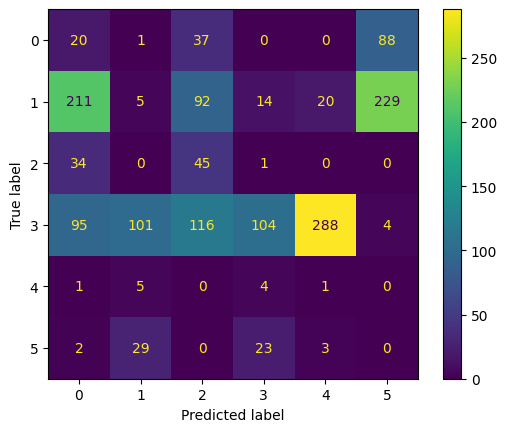

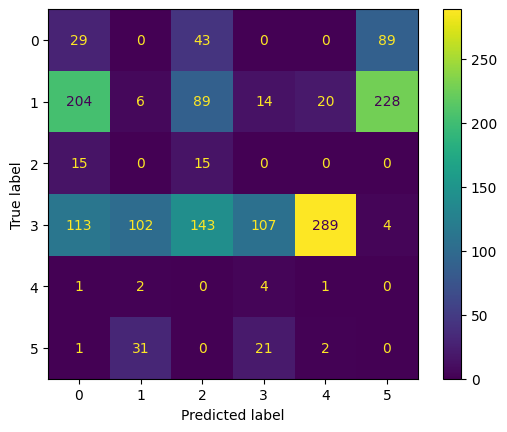

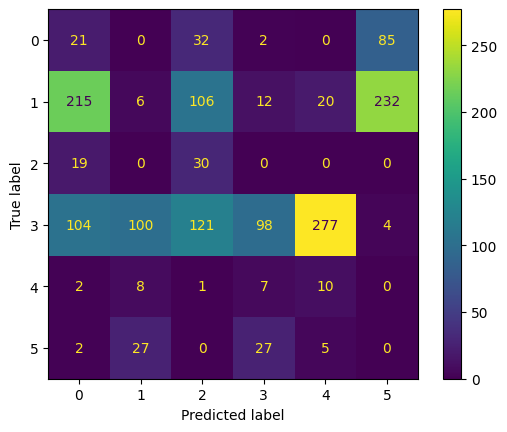

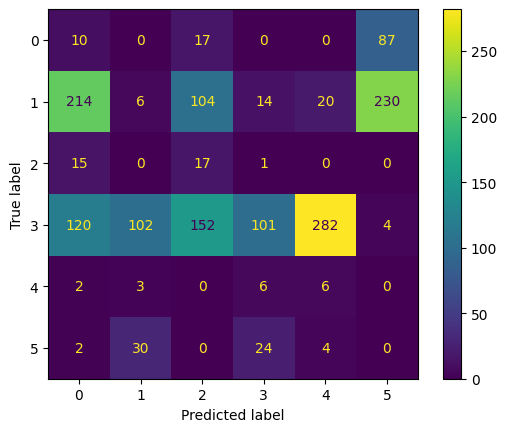

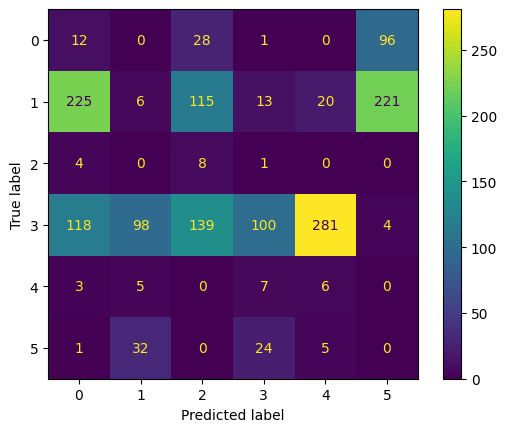

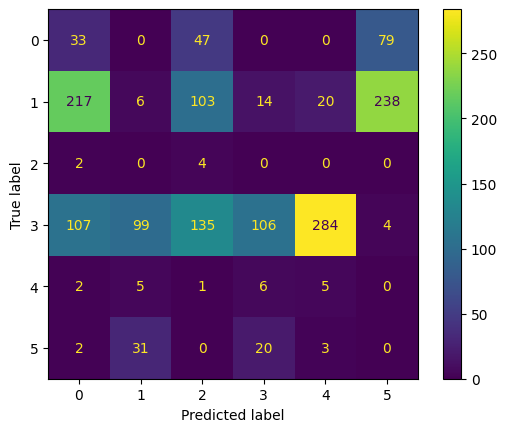

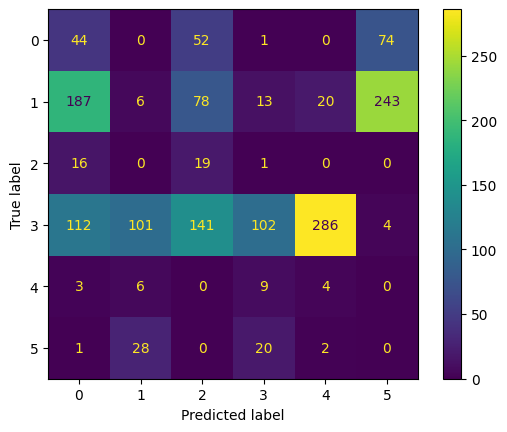

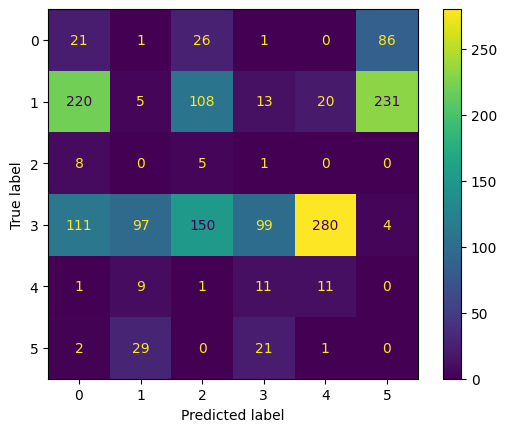

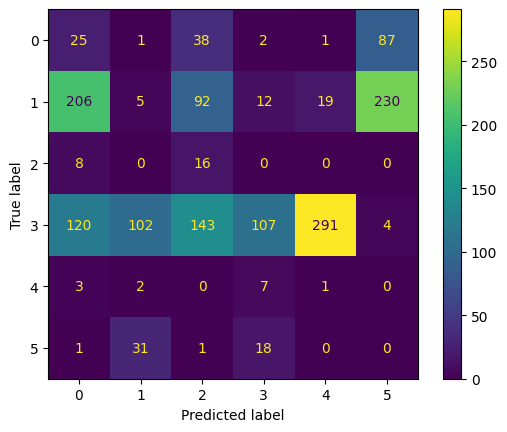

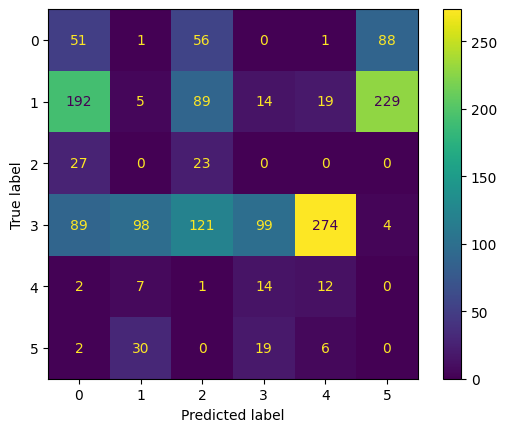

Mean accuracy (10 runs): 0.1007. Mean f1-score: 0.1283
Standard deviation accuracy (10 runs): 0.0110. Standard deviation f1-score: 0.0072


In [32]:
results = multi_run_experiment(combined_train_dset_fft, combined_target_dset_fft)

mean_acc = np.average(
    [res["result"][0]["accuracy"] for res in results["runs"]]
)
std_acc = np.std(
    [res["result"][0]["accuracy"] for res in results["runs"]]
)
mean_f1 = np.average(
    [res["result"][0]["f1 score (weighted)"] for res in results["runs"]]
)
std_f1 = np.std(
    [res["result"][0]["f1 score (weighted)"] for res in results["runs"]]
)
print(f"Mean accuracy (10 runs): {mean_acc:.4f}. Mean f1-score: {mean_f1:.4f}")
print(f"Standard deviation accuracy (10 runs): {std_acc:.4f}. Standard deviation f1-score: {std_f1:.4f}")

## Train and evaluate Support Vector Machine classifier

In [33]:
experiment = SimpleTrainEvalWorkflow(estimator=SVC, estimator_creation_kwags ={'C':3.0, 'kernel':"rbf"} , do_not_instantiate=False, do_fit=True, evaluator=reporter)
multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=10, debug=False)

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


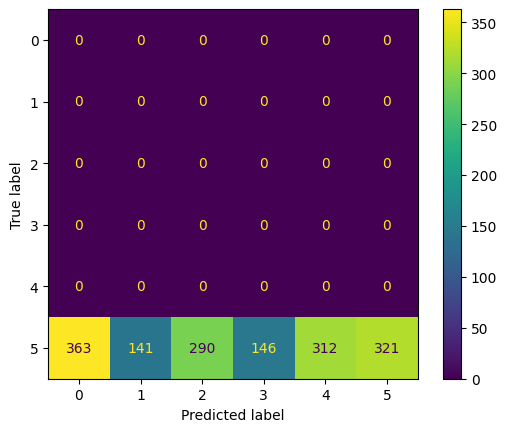

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


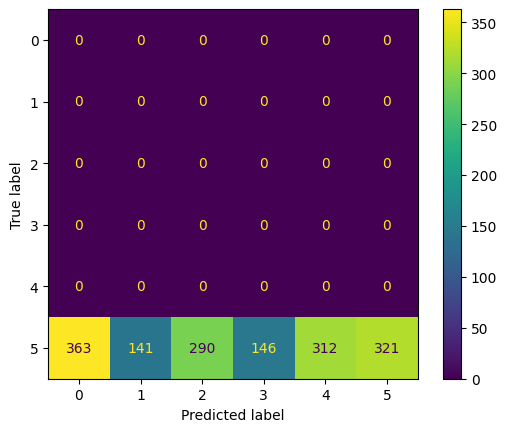

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


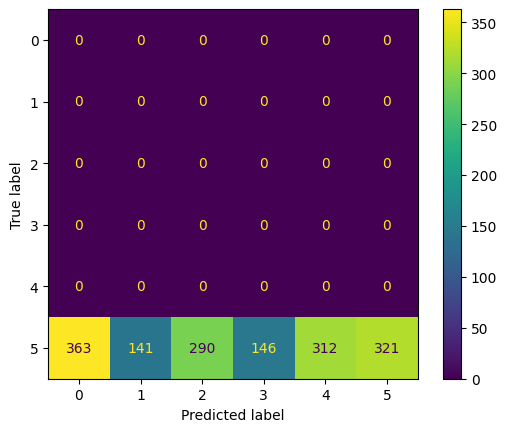

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


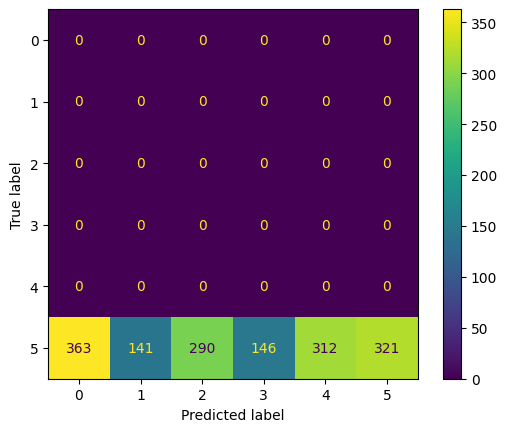

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


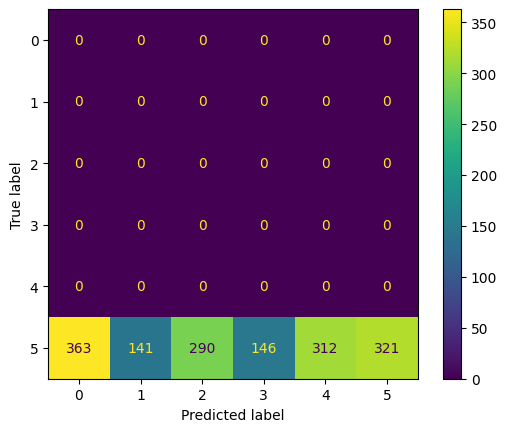

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


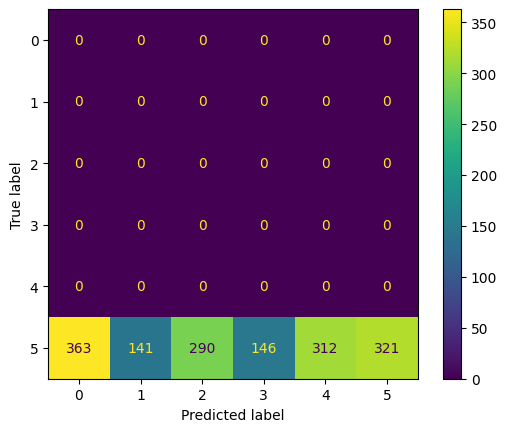

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


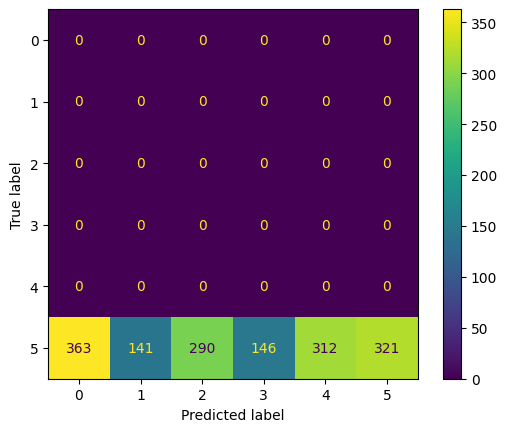

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


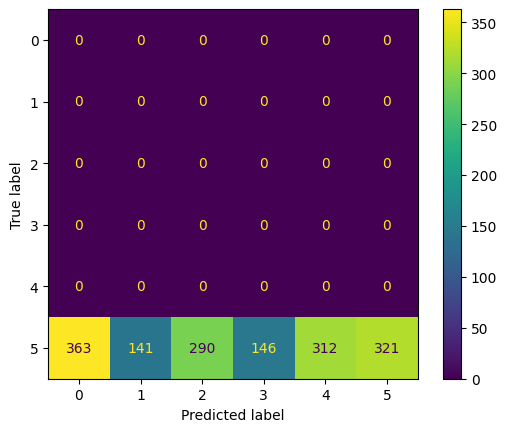

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


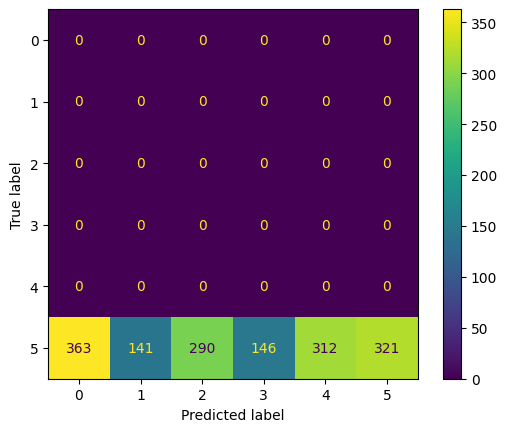

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


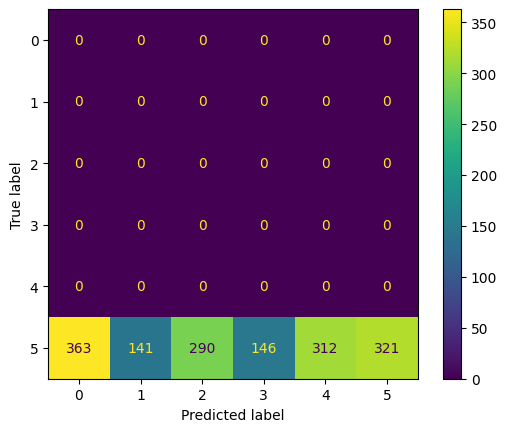

Mean accuracy (10 runs): 0.2041. Mean f1-score: 0.3390
Standard deviation accuracy (10 runs): 0.0000. Standard deviation f1-score: 0.0000


In [34]:
results = multi_run_experiment(combined_train_dset_fft, combined_target_dset_fft)

mean_acc = np.average(
    [res["result"][0]["accuracy"] for res in results["runs"]]
)
std_acc = np.std(
    [res["result"][0]["accuracy"] for res in results["runs"]]
)
mean_f1 = np.average(
    [res["result"][0]["f1 score (weighted)"] for res in results["runs"]]
)
std_f1 = np.std(
    [res["result"][0]["f1 score (weighted)"] for res in results["runs"]]
)
print(f"Mean accuracy (10 runs): {mean_acc:.4f}. Mean f1-score: {mean_f1:.4f}")
print(f"Standard deviation accuracy (10 runs): {std_acc:.4f}. Standard deviation f1-score: {std_f1:.4f}")

## Train and evaluate K Neighbors Classifier classifier

In [35]:
experiment = SimpleTrainEvalWorkflow(estimator=KNeighborsClassifier, estimator_creation_kwags ={'n_neighbors' :1} , do_not_instantiate=False, do_fit=True, evaluator=reporter)
multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=10, debug=False)

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


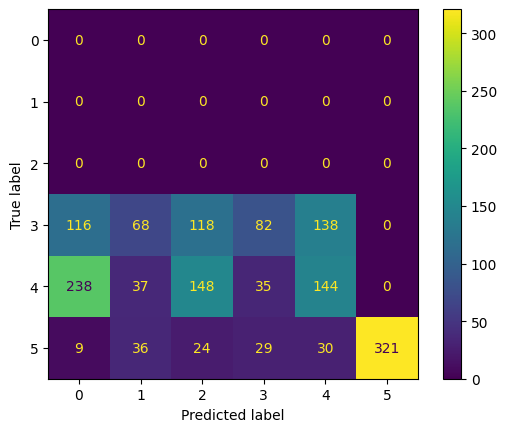

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


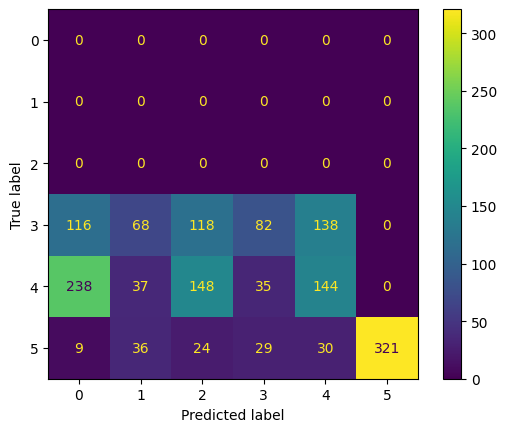

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


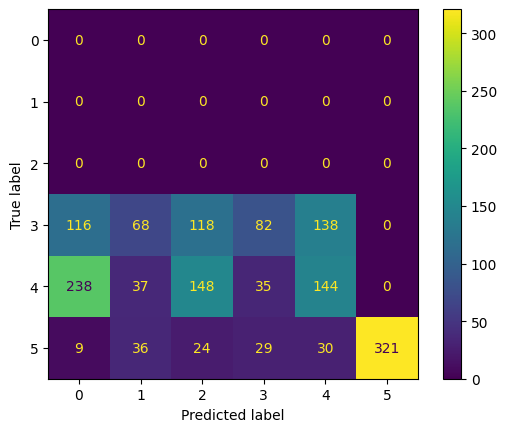

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


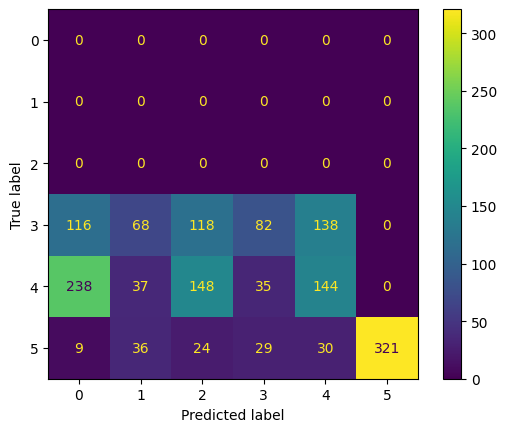

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


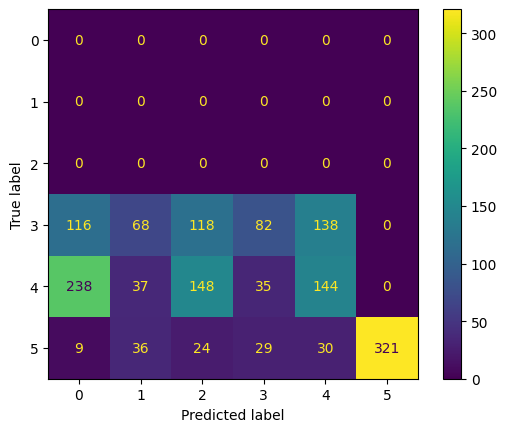

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


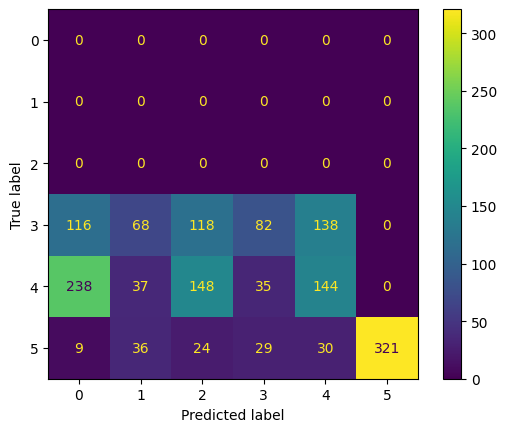

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


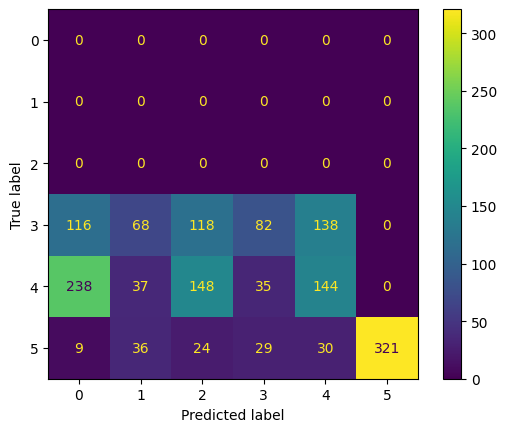

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


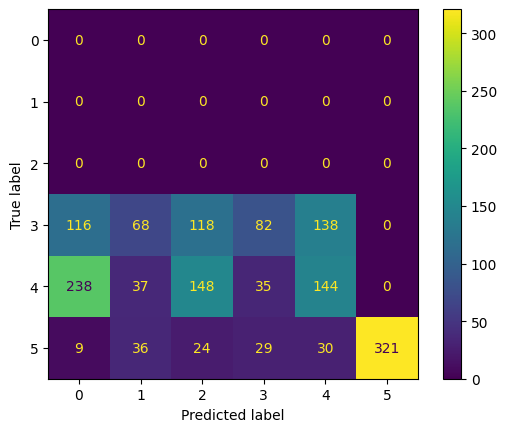

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


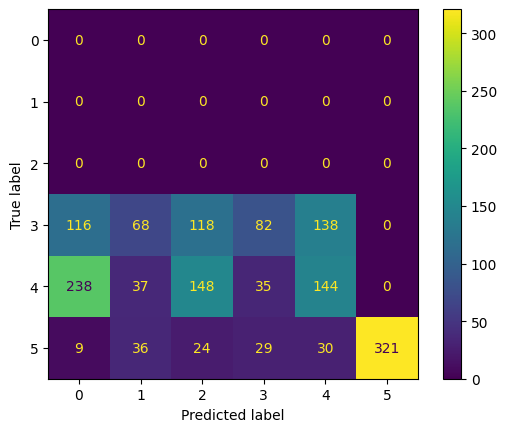

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


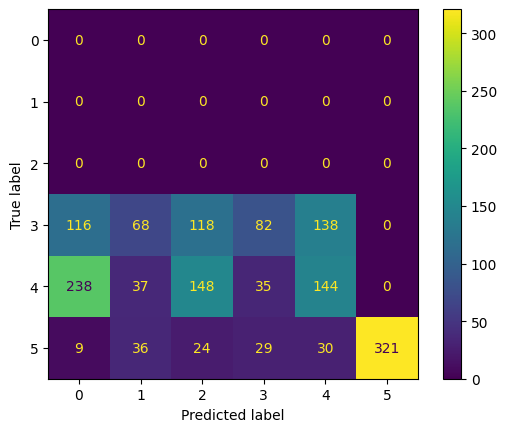

Mean accuracy (10 runs): 0.3477. Mean f1-score: 0.4401
Standard deviation accuracy (10 runs): 0.0000. Standard deviation f1-score: 0.0000


In [36]:
results = multi_run_experiment(combined_train_dset_fft, combined_target_dset_fft)

mean_acc = np.average(
    [res["result"][0]["accuracy"] for res in results["runs"]]
)
std_acc = np.std(
    [res["result"][0]["accuracy"] for res in results["runs"]]
)
mean_f1 = np.average(
    [res["result"][0]["f1 score (weighted)"] for res in results["runs"]]
)
std_f1 = np.std(
    [res["result"][0]["f1 score (weighted)"] for res in results["runs"]]
)
print(f"Mean accuracy (10 runs): {mean_acc:.4f}. Mean f1-score: {mean_f1:.4f}")
print(f"Standard deviation accuracy (10 runs): {std_acc:.4f}. Standard deviation f1-score: {std_f1:.4f}")